In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import torch
import transformers
import wandb

import generate_plots
import example_groups

from dataloader import DataLoader
from evaluate import load
from trainer import IndependentTrainer
from transformers import (
    AutoModelForSequenceClassification,
    TrainingArguments,
    DataCollatorWithPadding
)
from datasets import load_dataset
import seaborn as sns

os.environ["CUDA_VISIBLE_DEVICES"] = "0"

/vol/bitbucket/hrm20/fypenv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/vol/bitbucket/hrm20/fypenv/lib/python3.10/site-packages/transformers/utils/hub.py:128: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(


In [2]:
torch.cuda.empty_cache()

# Load Dataset

In [3]:
# os.environ["WANDB_MODE"] = "enabled"  # Enable wandb logging
# os.environ["WANDB_ENABLED"] = "true"  # Fully enable wandb

os.environ["WANDB_MODE"] = "disabled"  # Disable wandb logging
os.environ["WANDB_DISABLED"] = "true"  # Fully disable wandb

# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model_name = "prajjwal1/bert-tiny"
dataset_name = "multi_nli"

data_loader = DataLoader(dataset_name, model_name)
train_dataset, eval_dataset, tokenizer, num_labels = data_loader.prepare_datasets()

Using device: cuda


# Train

In [4]:
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=num_labels  # MNLI has 3 classes: entailment, contradiction, neutral
)
model.to(device)

# Load accuracy metric
metric = load("accuracy")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return metric.compute(predictions=predictions, references=labels)

run_methods = [
    "aum", 
    "datamaps", 
    "el2n",
    # "forgetting",
    # "grand",
    "loss"
]

# Training arguments
training_args = TrainingArguments(
    output_dir="bert-tiny-mnli",
    learning_rate=3e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=16,
    num_train_epochs=2,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    fp16=True
)


# wandb.init(
#     project="bert_tiny_mnli",
#     name=f"{training_args.num_train_epochs}_epochs_{dataset_name}_bert_tiny",
#     config=training_args.to_dict(),
# )

# Initialise trainer and train
trainer = IndependentTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    # tokenizer=tokenizer,
    # data_collator=DataCollatorWithPadding(tokenizer=tokenizer),
    # compute_metrics=compute_metrics,
    methods=run_methods,
    num_classes=num_labels,
    device=device
)

trainer.train(2)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at prajjwal1/bert-tiny and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/vol/bitbucket/hrm20/fypenv/lib/python3.10/site-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
Epoch 1/2: 100%|██████████| 12272/12272 [11:40<00:00, 17.52it/s, loss=0.655]


Epoch 1/2, Avg Loss: 0.8797


Epoch 2/2: 100%|██████████| 12272/12272 [11:36<00:00, 17.61it/s, loss=0.796]


Epoch 2/2, Avg Loss: 0.7830


In [5]:
# print(model)
print(model.classifier)

Linear(in_features=128, out_features=3, bias=True)


# Analysis

In [6]:
# grand_scores = trainer.get_unified_stats()['grand_scores']
el2n_scores = trainer.get_unified_stats()['el2n_scores']

In [7]:
mnli = load_dataset('multi_nli')
results = example_groups.get_example_group_results(mnli)

In [8]:
# grand_min = np.nanmin(grand_scores)
# grand_max = np.nanmax(grand_scores)

# print(grand_min)
# print(grand_max)

# # Avoid division by zero
# if grand_max - grand_min != 0:
#     normal_grand_scores = grand_scores/8
# else:
#     normal_grand_scores = np.zeros_like(grand_scores)

def min_max_normalize(scores):
    min_val = np.nanmin(scores)
    max_val = np.nanmax(scores)
    if max_val - min_val != 0:
        return (scores - min_val) / (max_val - min_val)
    else:
        return np.zeros_like(scores)

normalized_el2n = min_max_normalize(el2n_scores)
# normalized_grand = min_max_normalize(grand_scores)

normalized_el2n = el2n_scores
# normalized_grand = grand_scores

In [9]:
# grand_scores

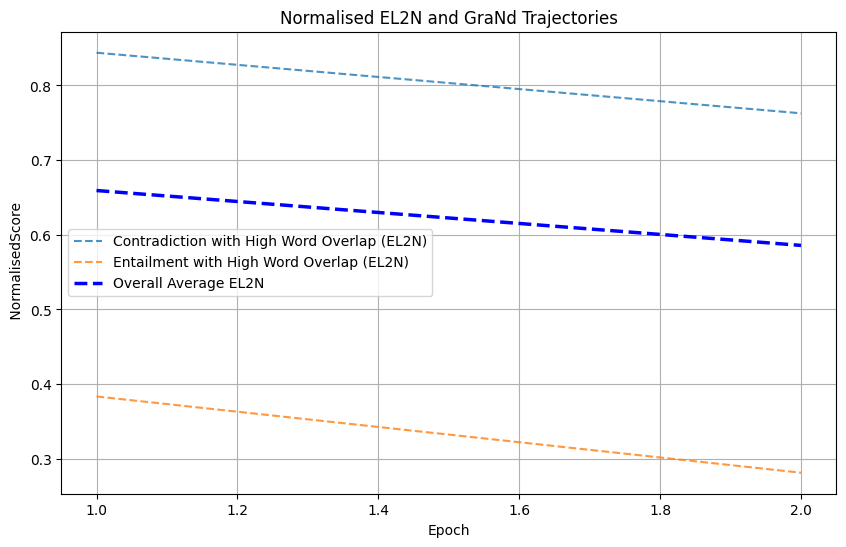

In [10]:
fig, ax = plt.subplots(figsize=(10, 6))

# Plot EL2N scores
for idx, (group, indices) in enumerate(results.items()):
    if not indices:
        continue

    # EL2N Scores
    group_el2n = normalized_el2n[:, indices]
    avg_el2n_per_epoch = np.nanmean(group_el2n, axis=1)

    ax.plot(range(1, len(avg_el2n_per_epoch) + 1),
            avg_el2n_per_epoch,
            label=f"{group} (EL2N)",
            linestyle='--',  # Dashed lines for EL2N
            alpha=0.8)

# Overall EL2N Average
overall_avg_el2n = np.nanmean(normalized_el2n, axis=1)
ax.plot(range(1, len(overall_avg_el2n) + 1),
        overall_avg_el2n,
        label='Overall Average EL2N',
        linestyle='--',
        linewidth=2.5,
        color='blue')

# Plot GraNd scores
# for idx, (group, indices) in enumerate(results.items()):
#     if not indices:
#         continue

#     # GraNd Scores
#     group_grand = normalized_grand[:, indices]
#     avg_grand_per_epoch = np.nanmean(group_grand, axis=1)

#     ax.plot(range(1, len(avg_grand_per_epoch) + 1),
#             avg_grand_per_epoch,
#             label=f"{group} (GraNd)",
#             linestyle='-',  # Solid lines for GraNd
#             alpha=0.8)

# # Overall GraNd Average
# overall_avg_grand = np.nanmean(normalized_grand, axis=1)
# ax.plot(range(1, len(overall_avg_grand) + 1),
#         overall_avg_grand,
#         label='Overall Average GraNd',
#         linestyle='-',
#         linewidth=2.5,
#         color='red')

# Graph Titles and Labels
ax.set_title("Normalised EL2N and GraNd Trajectories")
ax.set_xlabel("Epoch")
ax.set_ylabel(" NormalisedScore")
ax.legend()
ax.grid(True)

plt.show()

In [20]:
# forgetting_results = trainer.get_unified_stats()['forgetting_stats']['forgetting_events']
epoch_losses = trainer.get_unified_stats()['loss_stats']['epoch_losses']
per_sample_losses = trainer.get_unified_stats()['loss_stats']['per_sample_losses']
all_losses = trainer.get_unified_stats()['loss_stats']['all_losses']
data_map_stats = trainer.get_unified_stats()["data_map_stats"]
aum_scores = trainer.get_unified_stats()["aum_stats"]['aum_scores']
sample_margins = trainer.get_unified_stats()["aum_stats"]['sample_margins']


predictions = trainer.get_unified_stats()['predictions']
true_labels = trainer.get_unified_stats()['true_labels']

total_samples = len(train_dataset)

In [12]:
# all_losses[1][718]
# print(all_losses[0][44])
print(all_losses[0][57])
print(all_losses[0][58])
print(all_losses[0][59])
# print(np.mean(all_losses, axis=1))
# print(np.mean(grand_scores, axis=1))
# print(np.mean(el2n_scores, axis=1))

1.6903609037399292
0.3950572609901428
1.121708631515503


## Forgetting

In [13]:
plt = generate_plots.plot_forgetting_events(forgetting_results=forgetting_results, total_samples=total_samples)
plt.savefig("forgetting_events.png")
wandb.log({"Forgetting Events Chart": wandb.Image("forgetting_events.png")})

plt.tight_layout()
plt.show()

NameError: name 'forgetting_results' is not defined

## Losses

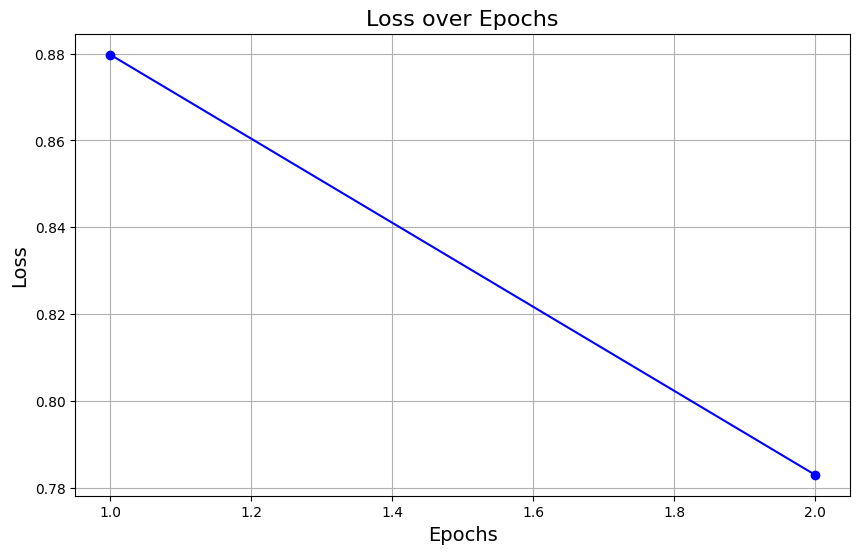

In [21]:
plt = generate_plots.plot_average_loss_over_epochs(epoch_losses)
plt.savefig("loss_over_epochs.png")
# wandb.log({"Loss over Epochs": wandb.Image("loss_over_epochs.png")})
plt.show()

In [22]:
print(epoch_losses)

[0.879747509396336, 0.7830335462500925]


## Example Groups

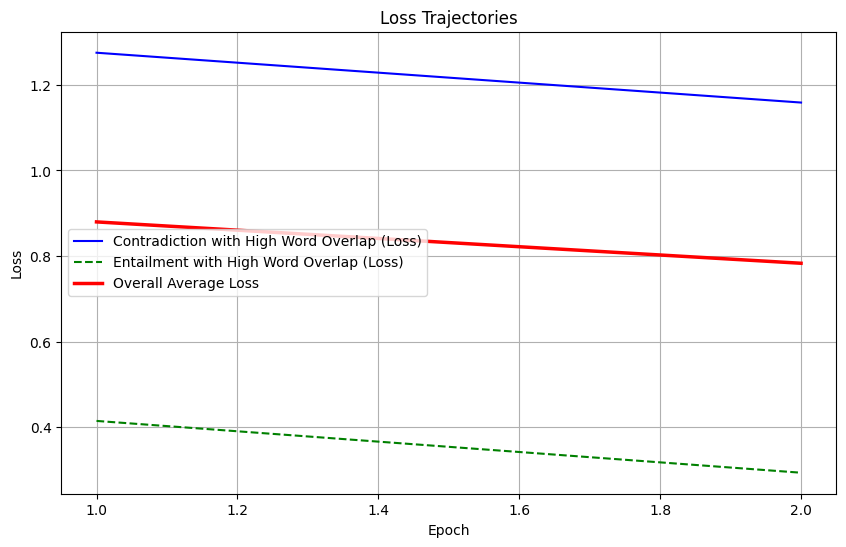

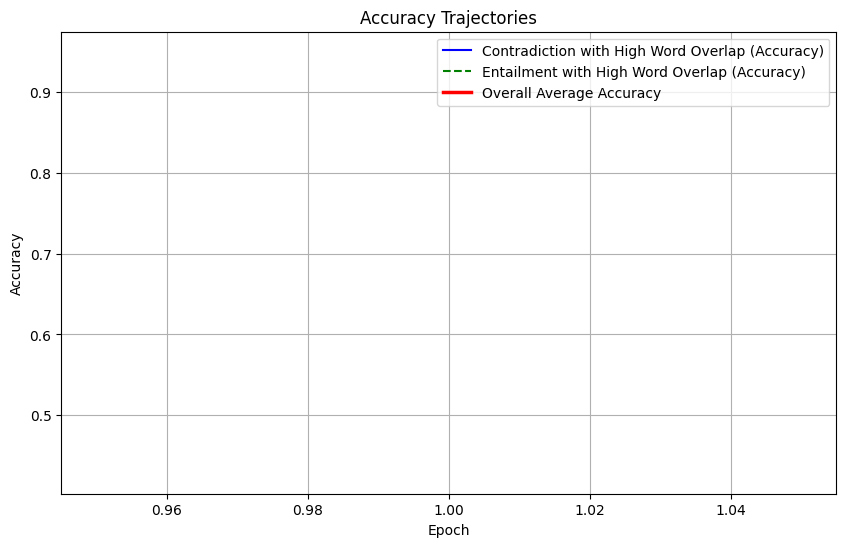

In [23]:
mnli = load_dataset('multi_nli')
fig1, fig2 = generate_plots.plot_losses_and_accuracies(mnli, all_losses, true_labels, predictions)
fig1.show()
fig2.show()

In [24]:
fig1.savefig("group_loss_trajectories.png")
fig2.savefig("group_accuracy_trajectories.png")
# wandb.log({"Loss Trajectories for High Word Overlap Groups": wandb.Image("group_loss_trajectories.png")})
# wandb.log({"Accuracy Trajectories for High Word Overlap Groups": wandb.Image("group_accuracy_trajectories.png")})

## Data Maps

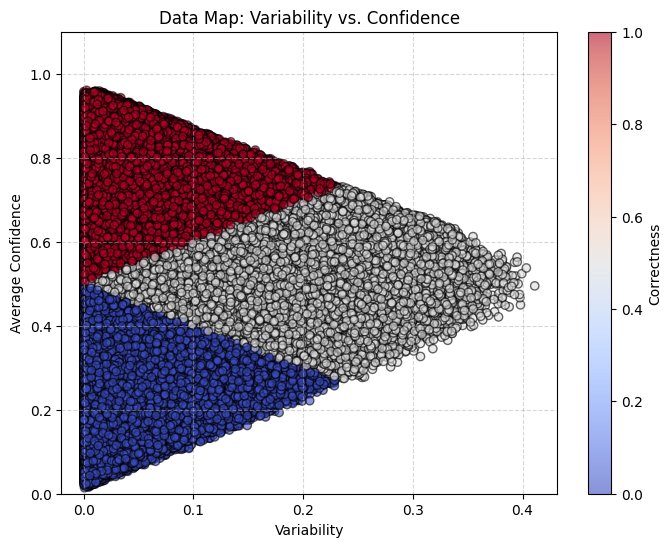

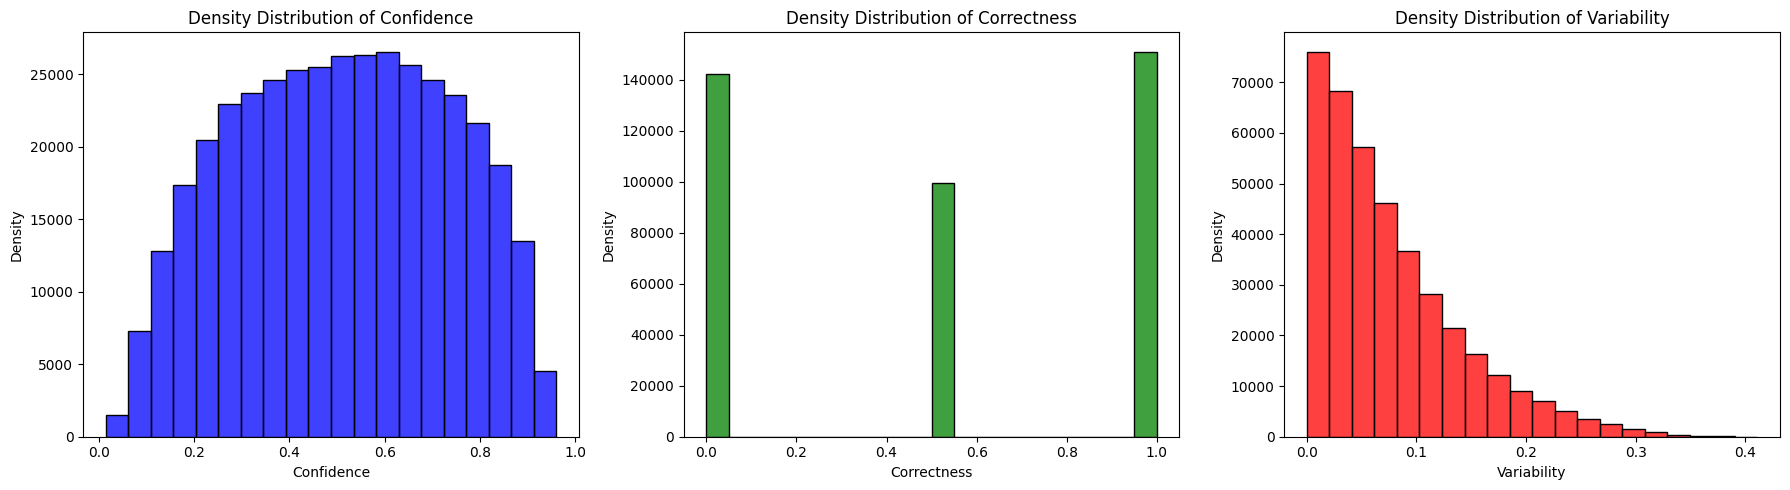

In [25]:
fig1, fig2 = generate_plots.plot_data_map(data_map_stats)
fig1.show()
fig2.show()
fig1.savefig("data_map.png")
fig2.savefig("data_map_variables.png")
# wandb.log({"Data Map: Variability vs Confidence": wandb.Image("data_map.png")})
# wandb.log({"Confidence, Correctness and Variability": wandb.Image("data_map_variables.png")})

Error: You must call wandb.init() before wandb.log()

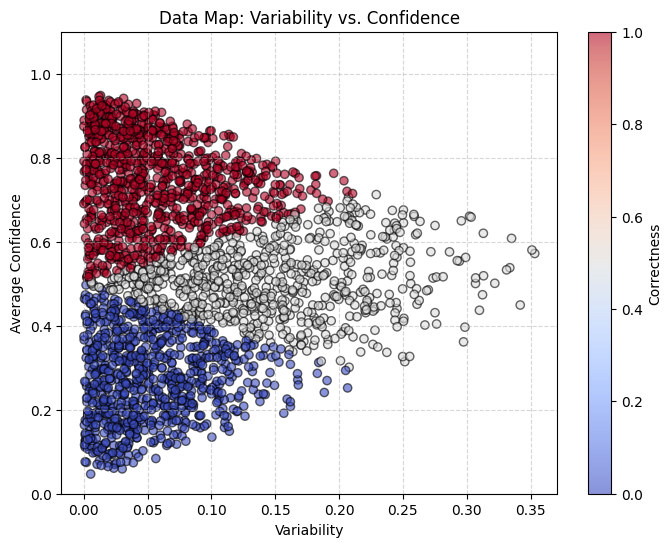

In [ ]:
def plot_data_map(data_map_stats):
    confidence = np.array(data_map_stats["confidence"][:2500])
    variability = np.array(data_map_stats["variability"][:2500])
    correctness = np.array(data_map_stats["correctness"][:2500])

    # --- First Figure: Scatter Plot ---
    fig1, ax1 = plt.subplots(figsize=(8, 6))
    scatter = ax1.scatter(variability, confidence, c=correctness, cmap="coolwarm", alpha=0.6, edgecolors="k")
    ax1.set_xlabel("Variability")
    ax1.set_ylabel("Average Confidence")
    ax1.set_ylim(0, 1.1)
    ax1.set_title("Data Map: Variability vs. Confidence")
    fig1.colorbar(scatter, ax=ax1, label="Correctness")
    ax1.grid(True, linestyle="--", alpha=0.5)
    return fig1
fig = plot_data_map(data_map_stats)
fig.show()
fig.savefig("data_map_2k_examples.png")
# wandb.log({"Smaller Data Map: Variability vs Confidence": wandb.Image("data_map_2k_examples.png")})

In [ ]:
confidence = np.array(data_map_stats["confidence"])
variability = np.array(data_map_stats["variability"])
correctness = np.array(data_map_stats["correctness"])

In [ ]:
print(variability[100:106])
print(confidence[100:106])

[0.09822032 0.11101593 0.10501045 0.08493199 0.16185758 0.13035144]
[0.56046216 0.77725233 0.28509405 0.27086996 0.33810133 0.26127107]


## AUM

In [ ]:
epoch = 2
print(predictions[epoch][:10])
print(true_labels[:10])

[0, 0, 1, 0, 0, 0, 1, 0, 0, 2]
[1, 0, 0, 0, 1, 0, 1, 0, 2, 2]


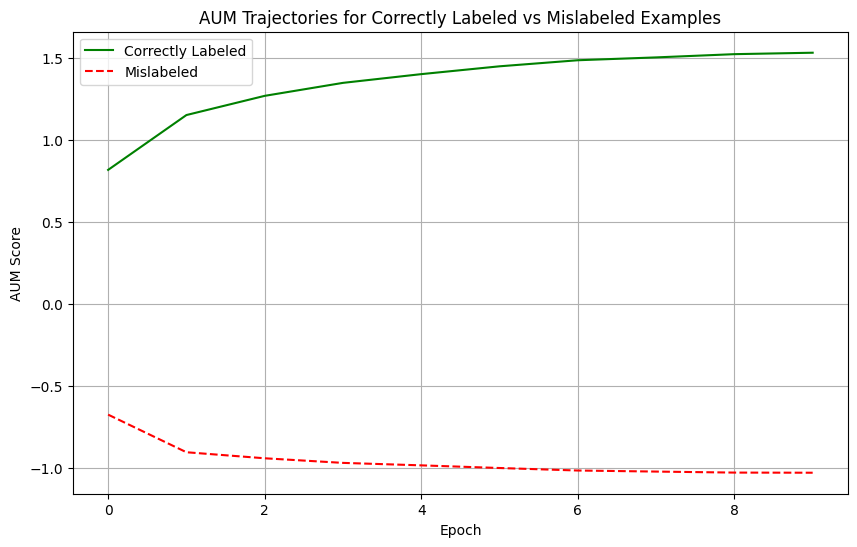

In [ ]:
plt = generate_plots.plot_aum(sample_margins, true_labels, predictions)
plt.show()

## Finishing Up

In [ ]:
wandb.log({
    "epoch_losses": epoch_losses,
    "per_sample_losses": per_sample_losses,
    "final_forgetting_stats": forgetting_results,
    "all_losses": all_losses,
    "data_map_stats": data_map_stats,
    "sample_margins": sample_margins,
    "predictions": predictions
})

wandb: WARNING Serializing object of type ndarray that is 3141728 bytes
wandb: WARNING Serializing object of type ndarray that is 3141728 bytes
wandb: WARNING Serializing object of type ndarray that is 3141728 bytes


In [ ]:
wandb.finish()

eval/accuracy,▁▄▅▆▇█████
eval/loss,█▅▄▃▂▁▁▁▁▁
eval/runtime,▅███▇▂▃▁▂▂
eval/samples_per_second,▄▁▁▁▂▇▆█▇▇
eval/steps_per_second,▄▁▁▁▂▇▆█▇▇
train/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇███
train/global_step,▁▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▆▆▆▇▇▇▇▇█████
train/grad_norm,▁▄▆▄▇▅▇▆▇▆▅▄▅▅▅▆█▆▅▆▆▆▇▇▇▇█▇▅▆▆▆▅▆▆█▅▇▇▆
train/learning_rate,███▇▇▇▇▇▇▇▆▆▆▆▅▅▅▅▄▄▄▄▄▄▄▄▃▃▃▃▂▂▂▂▂▂▁▁▁▁
train/loss,█▆▅▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eval/accuracy,0.67601
